### Load Library

In [3]:
%matplotlib inline
import os
os.chdir("/Users/liyanran/Desktop/23Fall/STCS6701probML/probML6701/hw1/spatial_analysis_heat-main")

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import seaborn as sns
import pyreadr

### Load Data

In [66]:
ts = pyreadr.read_r("./ts_heatindex_heatwarnings_byFIPS_2006_2016.RDS")
ts = ts[None]
print(ts.head())

   StateCounty_FIPS        Date  HImaxF_PopW    county     zone state  warn  \
0            1001.0  2006-04-01    81.951271   Autauga   AL-041    AL   0.0   
1            1001.0  2006-04-02    85.977650   Autauga   AL-041    AL   0.0   
2            1001.0  2006-04-03    82.727648   Autauga   AL-041    AL   0.0   
3            1001.0  2006-04-04    72.847272   Autauga   AL-041    AL   0.0   
4            1001.0  2006-04-05    76.618135   Autauga   AL-041    AL   0.0   

   adv  alert  
0  0.0    0.0  
1  0.0    0.0  
2  0.0    0.0  
3  0.0    0.0  
4  0.0    0.0  


In [67]:
# select columns
ts = ts[['HImaxF_PopW', 'alert']]

In [68]:
## continuous: normalization
# zscore -> Gaussian
def zscore(x, lognorm=False, EPS=1e-8):
    # robust zscore
    if lognorm:
        x = np.log(x)
    x = x - x.median()  # copy
    x /= np.abs(x).median() * 1.4826 + EPS
    x.clip(-3, 3, inplace=True)
    x -= x.mean()
    x /= x.std(ddof=0) + EPS
    return x

def preprosess(data):
    feat = ["HImaxF_PopW"]
    data.loc[:, feat] = data[feat].apply(zscore, lognorm=True)

    # delete na data
    data = data.dropna()
    
    return data

data = preprosess(ts)

/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [69]:
def split_ds(df, split_ratio=[0.7, 0.15]):
    
    np.random.seed(2)
    df = df.sample(frac=1)
    n = len(df)
    n_tr = int(n * split_ratio[0])
    n_va = int(n * split_ratio[1])
    
    train = df.values[: n_tr]
    valid = df.values[n_tr : n_tr + n_va]
    test = df.values[n_tr + n_va: ]
    
    return train, valid, test
    
train, valid, test = split_ds(data)

In [70]:
valid.shape

(1001721, 2)

In [71]:
train.shape

(4674698, 2)

Valid 0: 100%|██████████| 1956/1956 [00:04<00:00, 425.33it/s]


Log likilihood on validation: -353.46308951972696


Valid 1: 100%|██████████| 1956/1956 [00:07<00:00, 268.37it/s]


Log likilihood on validation: -353.62464572461835


Valid 2: 100%|██████████| 1956/1956 [00:05<00:00, 326.31it/s]


Log likilihood on validation: -353.453449459895


Valid 3: 100%|██████████| 1956/1956 [00:04<00:00, 474.13it/s]


Log likilihood on validation: -353.4606348361462


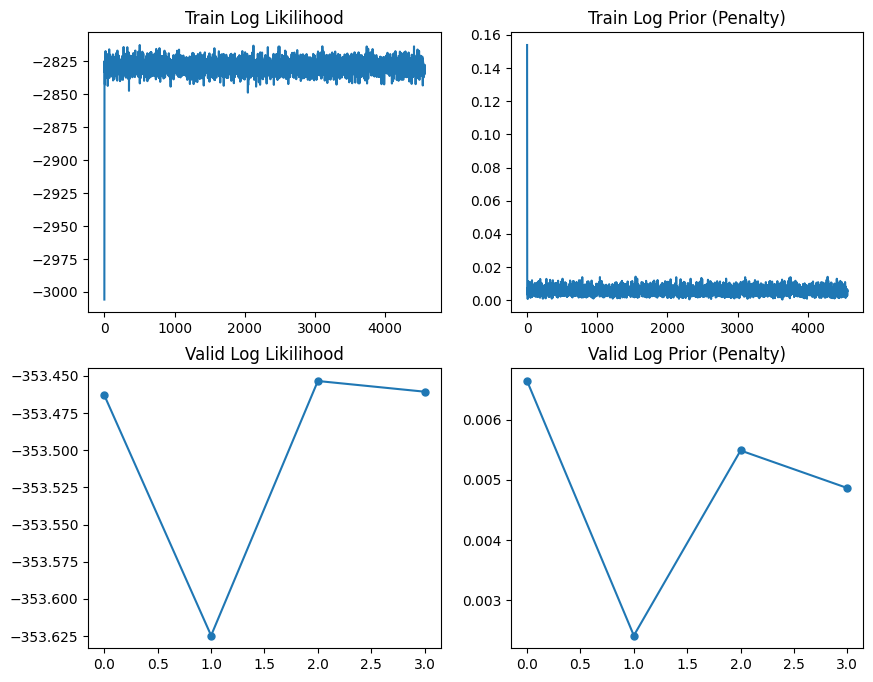

In [80]:
def set_seed(seed=2):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

## hyper parameters
args = dict(
    batchsize = 4096,
    lamb = 0.5,
    n_epochs = 4,
    lr = 1e-3,
    verbose=True,
)


def train_epoch(epoch, loader, model, opt, eval_dict, args):
    
    lamb = args["lamb"]
    for batch in tqdm(loader, desc=f"Train {epoch}", disable=not args["verbose"]):
        X, y = batch[:, :-1].float(), batch[:, -1].long()
        logits = X @ model
        reg = 0.5 * lamb * (model**2).sum()
        LL = torch.sum(y * logits.sigmoid().log() + (1-y) * (-logits).sigmoid().log())
        (- reg - LL).backward()
        opt.step()
        opt.zero_grad()
        eval_dict["LL"].append(LL.item())
        eval_dict["penalty"].append(reg.item())
    return eval_dict
    
def eval_epoch(epoch, loader, model, prefix="Valid", args=None):
    lamb = args["lamb"]
    res = {"LL":[], "penalty":[]}
    for batch in tqdm(loader, desc=f"{prefix} {epoch}", disable=not args["verbose"]):
        X, y = batch[:, :-1].float(), batch[:, -1].long()
        logits = X @ model
        reg = 0.5 * lamb * (model**2).sum()
        LL = torch.sum(y * logits.sigmoid().log() + (1-y) * (-logits).sigmoid().log())
        res["LL"].append(LL.item())
        res["penalty"].append(reg.item())
    return res
    
def main(data, args):
    ## hyper params
    batchsize = args["batchsize"]
    n_epochs = args["n_epochs"]
    lamb = args["lamb"]
    lr = args["lr"]
    n_feat = data.shape[1] - 1
    
    ## data
    train_loader = torch.utils.data.DataLoader(train, batch_size=batchsize, shuffle=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=512, drop_last=True)

    ## model and optimizer
    beta = nn.Parameter(torch.normal(mean=torch.zeros(n_feat), std=torch.ones(n_feat)/lamb))
    opt = torch.optim.SGD([beta], lr=lr)

    ## records
    train_ll = {"LL":[], "penalty":[]}
    valid_ll = {"LL":[], "penalty":[]}
    best = {"LL": -np.inf, "epoch":0, "model":[beta]}
    for epoch in range(n_epochs):
        train_epoch(epoch, train_loader, beta, opt, train_ll, args)
        res = eval_epoch(epoch, valid_loader, beta, "Valid", args)
        valid_ll["LL"].append(np.mean(res["LL"]))
        valid_ll["penalty"].append(np.mean(res["penalty"]))
        LL = np.mean(res["LL"]) # + np.mean(res["penalty"])
        if args["verbose"]:
            print(f"Log likilihood on validation: {LL}")
        if LL > best["LL"]:
            best["LL"] = np.mean(res["LL"]) + np.mean(res["penalty"])
            best["epoch"] = epoch
            best["model"] = copy.deepcopy(beta)

    ## plot
    train_ll = pd.DataFrame(train_ll)
    valid_ll = pd.DataFrame(valid_ll)
    if args["verbose"]:
        fig, axes = plt.subplots(2,2, figsize=(10,8))
        axes = axes.flatten()
        _ = train_ll.LL.plot(title="Train Log Likilihood", ax=axes[0])
        _ = train_ll.penalty.plot(title="Train Log Prior (Penalty)", ax=axes[1])

        _ = valid_ll.LL.plot(title="Valid Log Likilihood", ax=axes[2], ms=5, style="-o")
        _ = valid_ll.penalty.plot(title="Valid Log Prior (Penalty)", ax=axes[3], ms=5, style="-o")

    return valid_ll, best

t, best = main(data, args)

In [77]:
res = pd.DataFrame(best["model"].detach().numpy(), index=data.columns[:-1], columns=["coef"])
print(res.to_latex())

\begin{tabular}{lr}
\toprule
 & coef \\
\midrule
HImaxF_PopW & 0.144471 \\
\bottomrule
\end{tabular}



100%|██████████| 6/6 [21:22<00:00, 213.80s/it]


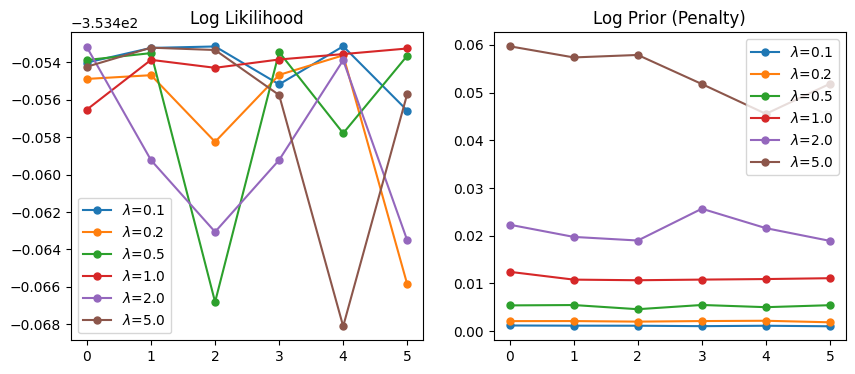

In [79]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for prior in tqdm([.1, .2, .5, 1., 2., 5.]):
    
    args = dict(
        batchsize = 5120,
        lamb = prior,
        n_epochs = 6,
        lr = 1e-4,
        verbose=False,
    )
    t, _  = main(data, args)
    LL, penalty = t.LL, t.penalty
    LL.name = f"$\lambda$={prior}"
    penalty.name = f"$\lambda$={prior}"
    LL.plot(title=f"Log Likilihood", ax=axes[0], ms=5, style="-o", legend=True)
    penalty.plot(title="Log Prior (Penalty)", ax=axes[1], ms=5, style="-o", legend=True)